In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy.stats import pearsonr
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import colorcet as cc

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

# from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
#                      ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/scratch/daanr/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

In [9]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/scratch/daanr/arctic-connectivity/tools/advectParticles.py'>

In [18]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/daanr/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/community/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/community/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/community/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/community/communities/"

In [19]:
with open('/scratch/daanr/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

## March 2009-2018 (90 Days)

In [20]:
avg_mixing_march_2009_2018 = np.zeros_like(myBins.bindex)
avg_coherence_march_2009_2018 = np.zeros_like(myBins.bindex)
avg_boundary_march_2009_2018 = np.zeros_like(myBins.bindex)

for year in range(2009, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_march_2009_2018 = avg_mixing_march_2009_2018 + results['avg_mixing']
    avg_coherence_march_2009_2018 = avg_coherence_march_2009_2018 + results['avg_coherence']
    avg_boundary_march_2009_2018 = avg_boundary_march_2009_2018 + results['avg_boundary']

avg_mixing_march_2009_2018 = avg_mixing_march_2009_2018/10
avg_coherence_march_2009_2018 = avg_coherence_march_2009_2018/10
avg_boundary_march_2009_2018 = avg_boundary_march_2009_2018/10

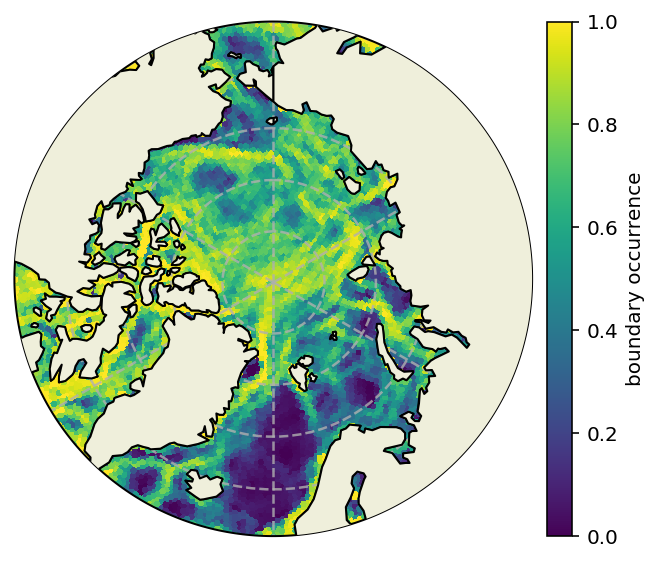

In [10]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

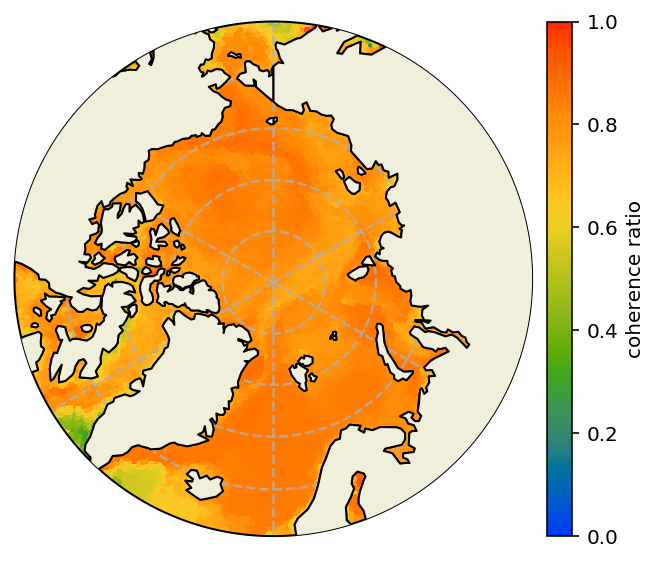

In [7]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio",
                                             export = "coherence_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

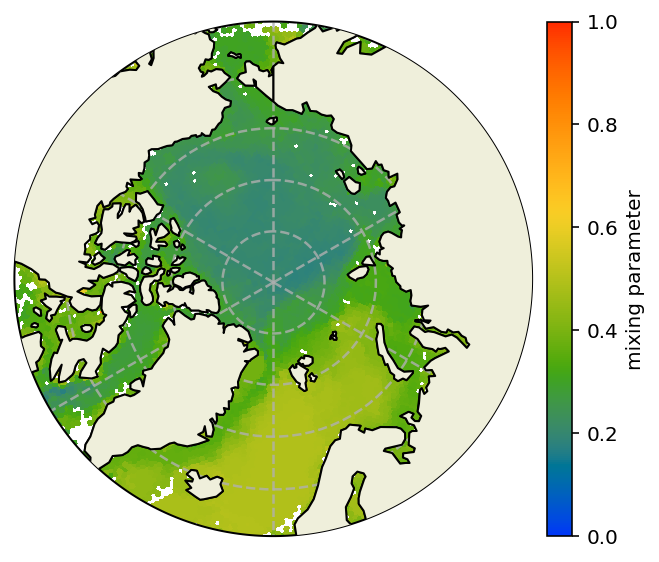

In [9]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter",
                                             export = "mixing_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

## 30 days

In [22]:
avg_mixing_march_2009_2018_30d = np.zeros_like(myBins.bindex)
avg_coherence_march_2009_2018_30d = np.zeros_like(myBins.bindex)
avg_boundary_march_2009_2018_30d = np.zeros_like(myBins.bindex)

for year in range(2009, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_subD30_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_march_2009_2018_30d = avg_mixing_march_2009_2018_30d + results['avg_mixing']
    avg_coherence_march_2009_2018_30d = avg_coherence_march_2009_2018_30d + results['avg_coherence']
    avg_boundary_march_2009_2018_30d = avg_boundary_march_2009_2018_30d + results['avg_boundary']

avg_mixing_march_2009_2018_30d = avg_mixing_march_2009_2018_30d/10
avg_coherence_march_2009_2018_30d = avg_coherence_march_2009_2018_30d/10
avg_boundary_march_2009_2018_30d = avg_boundary_march_2009_2018_30d/10

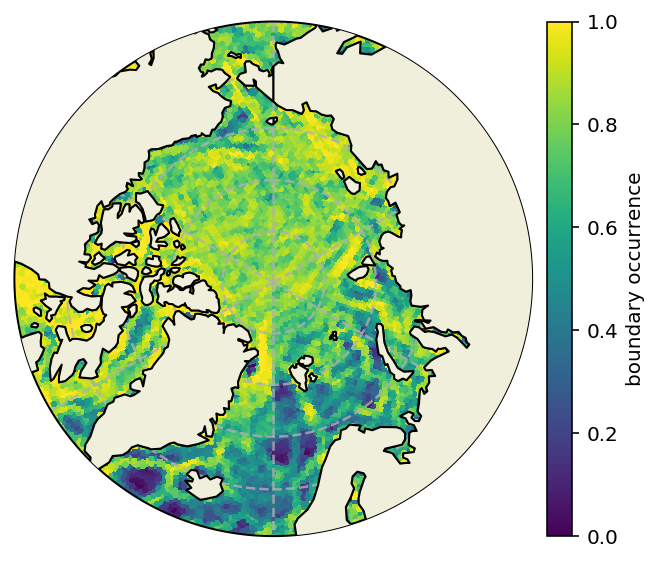

In [16]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_2009_2018_30d[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_subD30_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

## September 2009-2018

In [26]:
avg_mixing_september_2009_2018 = np.zeros_like(myBins.bindex)
avg_coherence_september_2009_2018 = np.zeros_like(myBins.bindex)
avg_boundary_september_2009_2018 = np.zeros_like(myBins.bindex)

concat_codelengths_2009_2018 = np.array([])
concat_globalMixing_2009_2018 = np.array([])
concat_globalCoherence_2009_2018 = np.array([])

for year in range(2009, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_september_2009_2018 = avg_mixing_september_2009_2018 + results['avg_mixing']
    avg_coherence_september_2009_2018 = avg_coherence_september_2009_2018 + results['avg_coherence']
    avg_boundary_september_2009_2018 = avg_boundary_september_2009_2018 + results['avg_boundary']
    concat_codelengths_2009_2018 = np.append(concat_codelengths_2009_2018, np.array(results['codelengths']))
    concat_globalMixing_2009_2018 = np.append(concat_globalMixing_2009_2018, np.array(results['globalMixing']))
    concat_globalCoherence_2009_2018 = np.append(concat_globalCoherence_2009_2018, np.array(results['globalCoherence']))

avg_mixing_september_2009_2018 = avg_mixing_september_2009_2018/10
avg_coherence_september_2009_2018 = avg_coherence_september_2009_2018/10
avg_boundary_september_2009_2018 = avg_boundary_september_2009_2018/10

In [38]:
results_2009_2019 = pd.DataFrame(data = {"codelengths": concat_codelengths_2009_2018, "globalMixing": concat_globalMixing_2009_2018, "globalCoherence": concat_globalCoherence_2009_2018})

In [40]:
results_2009_2019.corr()

codelengths  globalMixing  globalCoherence
codelengths         1.000000     -0.093449         0.178278
globalMixing       -0.093449      1.000000        -0.194069
globalCoherence     0.178278     -0.194069         1.000000

In [43]:
results_2009_2019.corr(method=lambda x, y: pearsonr(x, y)[1])

codelengths  globalMixing  globalCoherence
codelengths      1.000000e+00  3.097523e-03     1.377763e-08
globalMixing     3.097523e-03  1.000000e+00     6.083691e-10
globalCoherence  1.377763e-08  6.083691e-10     1.000000e+00

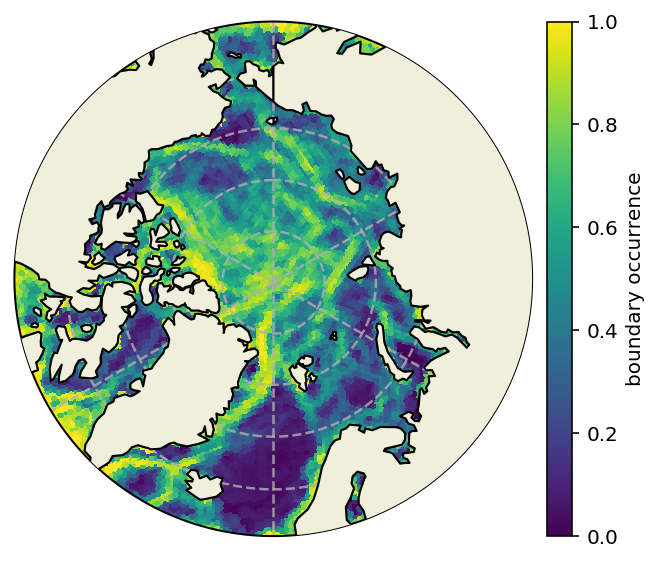

In [12]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

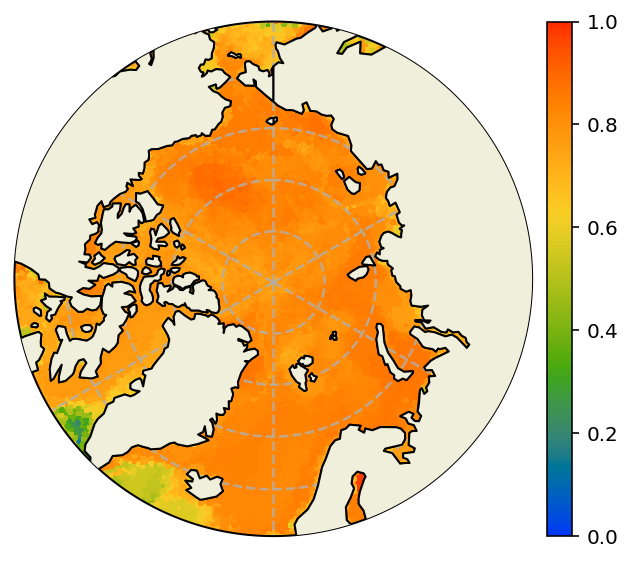

In [37]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"coherence_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                            )

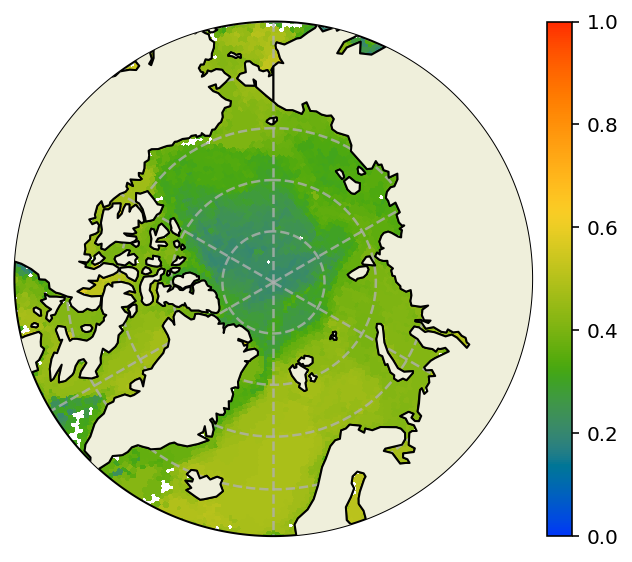

In [38]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"mixing_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True
                                            )

In [11]:
multiFiles = []
for year in range(2009, 2019):
    for month in ["09", "10", "11"]:
        multiFiles.append(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}{month}.nc")
ds_septoctnov_20092018 = xr.open_mfdataset(multiFiles) 

/science/users/4302001/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/science/users/4302001/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [12]:
ds_septoctnov_20092018.uo[:, 0, 1680:, :]

<xarray.DataArray 'uo' (time: 30, latitude: 361, longitude: 4320)>
dask.array<getitem, shape=(30, 361, 4320), dtype=float32, chunksize=(1, 361, 4320)>
Coordinates:
    depth      float32 0.494025
  * latitude   (latitude) float32 60.0 60.083332 60.166668 ... 89.916664 90.0
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * time       (time) datetime64[ns] 2009-09-16 ... 2018-11-16
Attributes:
    long_name:      Eastward velocity
    standard_name:  eastward_sea_water_velocity
    units:          m s-1
    unit_long:      Meters per second
    cell_methods:   area: mean

In [13]:
meanvelo_septoctnov_20092018 = np.mean(np.sqrt(np.square(ds_septoctnov_20092018.uo[:, 0, 1680:, :]) + np.square(ds_septoctnov_20092018.vo[:, 0, 1680:, :])), axis=0).compute()

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
meansiconc = np.mean(ds_septoctnov_20092018.siconc[:, 1680:, :], axis=0)

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


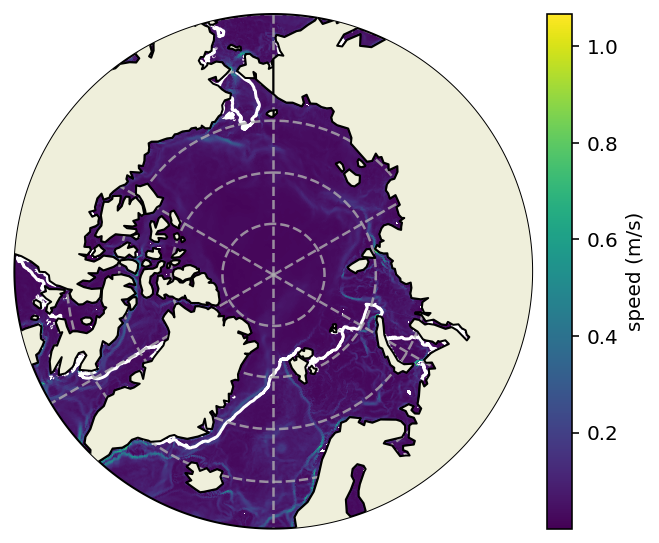

In [16]:
fig, ax = plot.field_from_dataset(ds_septoctnov_20092018.longitude, 
                                    ds_septoctnov_20092018.latitude[1680:], 
                                    meanvelo_septoctnov_20092018, 
                                    latRange=(60,90), 
                                    polar=True,
                                    size=(5,5),
                                    land=True,
                                    units = "speed (m/s)")
ax.contour(ds_septoctnov_20092018.longitude, 
           ds_septoctnov_20092018.latitude[1680:], 
           meansiconc, levels=np.array([0.15]), 
           colors='white', 
           transform=ccrs.PlateCarree())

In [17]:
meshlon, meshlat= np.meshgrid(ds_septoctnov_20092018.longitude, ds_septoctnov_20092018.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
veloVals = np.where(np.isnan(meanvelo_septoctnov_20092018.data.flatten()), 0, meanvelo_septoctnov_20092018.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedVelocity = griddata(dataPoints, veloVals, binPoints, method="nearest")

In [18]:
meshlon, meshlat= np.meshgrid(ds_septoctnov_20092018.longitude, ds_septoctnov_20092018.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
iceVals = np.where(np.isnan(meansiconc.data.flatten()), 0, meansiconc.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedIce = griddata(dataPoints, iceVals, binPoints, method="nearest")

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


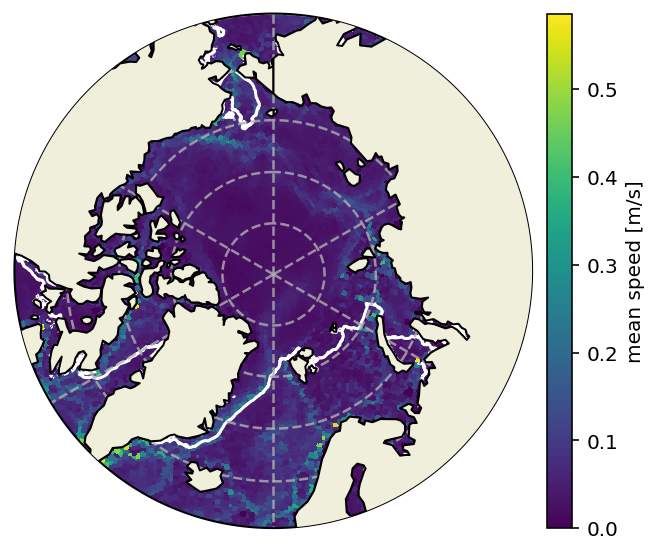

In [19]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedVelocity[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             cbar = True,
                                             polar = True,
                                             units = r"mean speed [m/s]",
                                            )
ax.contour(ds_septoctnov_20092018.longitude, 
           ds_septoctnov_20092018.latitude[1680:], 
           meansiconc, levels=np.array([0.15]), 
           colors='white', 
           transform=ccrs.PlateCarree())
plt.savefig(f"figures/mean_speed_20092018septoctnov.png", dpi=300, bbox_inches='tight')

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


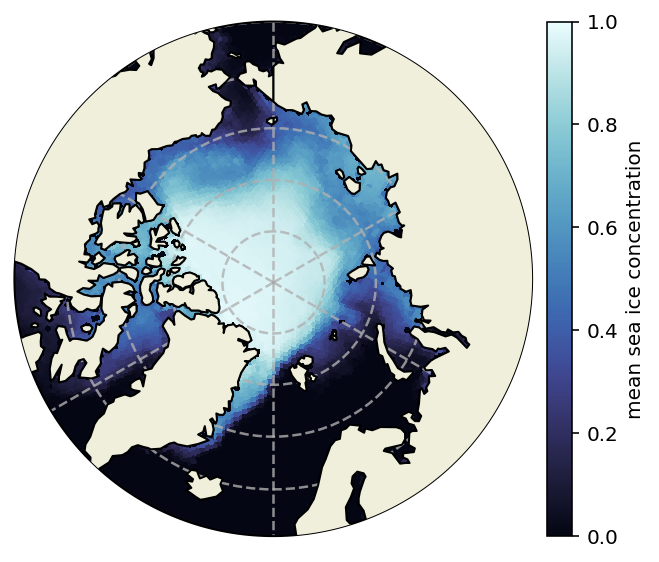

In [22]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedIce[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             colormap = cmocean.cm.ice, vmin=0, vmax=1,
                                             land = True,
                                             size = (5,5),
                                             cbar = True,
                                             polar = True,
                                             units = r"mean sea ice concentration",
                                            )
plt.savefig(f"figures/mean_ice_20092018septoctnov.png", dpi=300, bbox_inches='tight')

In [26]:
from scipy.stats import pearsonr

In [44]:
icemask = (interpolatedIce < 0.15).compute()
pearsonr(interpolatedVelocity[np.logical_or(myBins.oceanMask, icemask)],
         avg_boundary_september_2009_2018[np.logical_or(myBins.oceanMask, icemask)])

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.3750968337440129, 0.0)

In [45]:
pearsonr(interpolatedVelocity[myBins.oceanMask],
         avg_boundary_september_2009_2018[myBins.oceanMask])

(-0.0065387126921753955, 0.5949505506965279)

In [46]:
pearsonr(interpolatedIce[myBins.oceanMask],
         avg_coherence_september_2009_2018[myBins.oceanMask])

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.21330800266799618, 6.311893617849913e-69)

In [47]:
pearsonr(interpolatedIce[myBins.oceanMask],
         avg_mixing_september_2009_2018[myBins.oceanMask])

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(-0.24137979260682543, 2.615379193559762e-88)

## 30 days

In [23]:
avg_mixing_september_2009_2018_30d = np.zeros_like(myBins.bindex)
avg_coherence_september_2009_2018_30d = np.zeros_like(myBins.bindex)
avg_boundary_september_2009_2018_30d = np.zeros_like(myBins.bindex)

for year in range(2009, 2019):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_subD30_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_september_2009_2018_30d = avg_mixing_september_2009_2018_30d + results['avg_mixing']
    avg_coherence_september_2009_2018_30d = avg_coherence_september_2009_2018_30d + results['avg_coherence']
    avg_boundary_september_2009_2018_30d = avg_boundary_september_2009_2018_30d + results['avg_boundary']

avg_mixing_september_2009_2018_30d = avg_mixing_september_2009_2018_30d/10
avg_coherence_september_2009_2018_30d = avg_coherence_september_2009_2018_30d/10
avg_boundary_september_2009_2018_30d = avg_boundary_september_2009_2018_30d/10

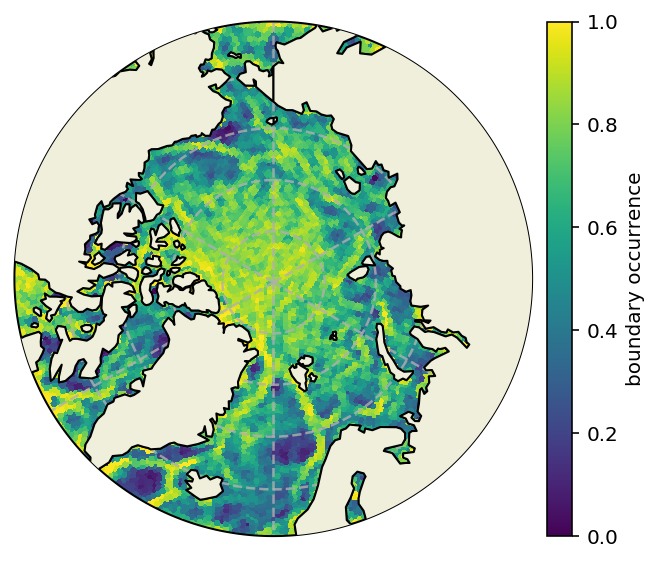

In [14]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_2009_2018_30d[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_subD30_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

## March 1993-2002 (90 Days)

In [48]:
avg_mixing_march_1993_2002 = np.zeros_like(myBins.bindex)
avg_coherence_march_1993_2002 = np.zeros_like(myBins.bindex)
avg_boundary_march_1993_2002 = np.zeros_like(myBins.bindex)

for year in range(1993, 2003):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_march_1993_2002 = avg_mixing_march_1993_2002 + results['avg_mixing']
    avg_coherence_march_1993_2002 = avg_coherence_march_1993_2002 + results['avg_coherence']
    avg_boundary_march_1993_2002 = avg_boundary_march_1993_2002 + results['avg_boundary']

avg_mixing_march_1993_2002 = avg_mixing_march_1993_2002/10
avg_coherence_march_1993_2002 = avg_coherence_march_1993_2002/10
avg_boundary_march_1993_2002 = avg_boundary_march_1993_2002/10

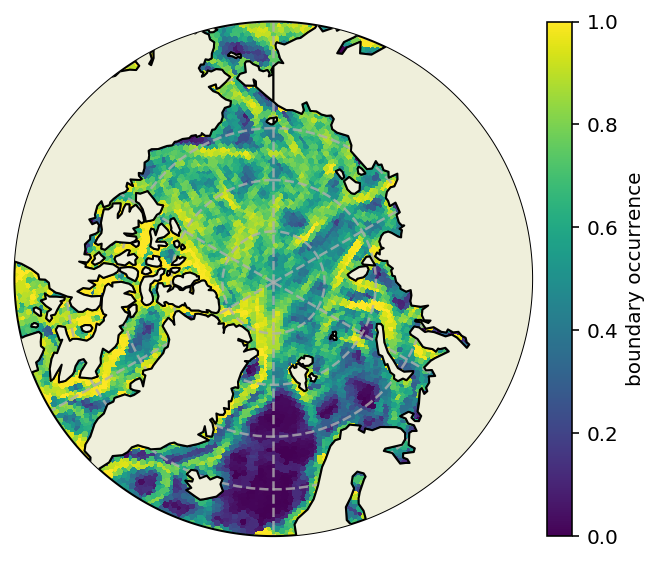

In [49]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

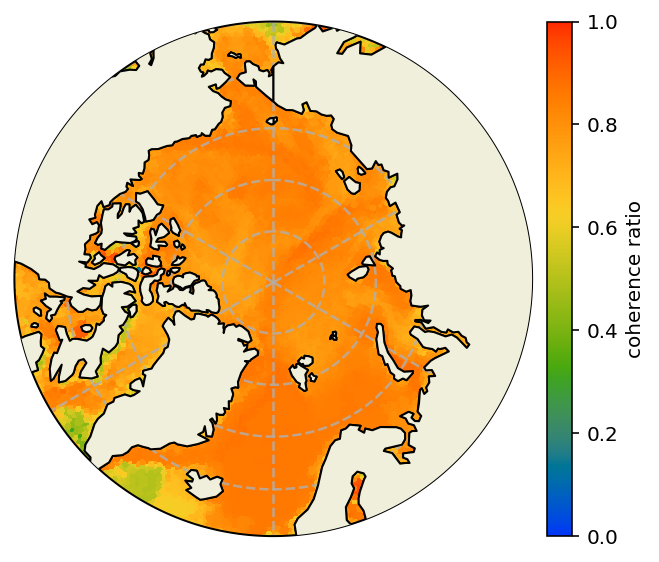

In [50]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio",
                                             export = "coherence_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

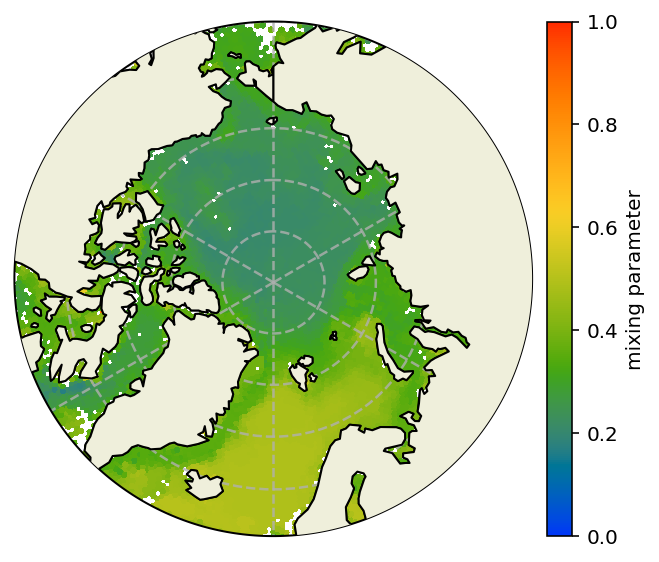

In [51]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter",
                                             export = "mixing_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

## September 1993-2002 (90 Days)

In [24]:
avg_mixing_september_1993_2002 = np.zeros_like(myBins.bindex)
avg_coherence_september_1993_2002 = np.zeros_like(myBins.bindex)
avg_boundary_september_1993_2002 = np.zeros_like(myBins.bindex)

for year in range(1993, 2003):
    with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2/ensembleResults_network_Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24_Cico7_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile)
    
    avg_mixing_september_1993_2002 = avg_mixing_september_1993_2002 + results['avg_mixing']
    avg_coherence_september_1993_2002 = avg_coherence_september_1993_2002 + results['avg_coherence']
    avg_boundary_september_1993_2002 = avg_boundary_september_1993_2002 + results['avg_boundary']

avg_mixing_september_1993_2002 = avg_mixing_september_1993_2002/10
avg_coherence_september_1993_2002 = avg_coherence_september_1993_2002/10
avg_boundary_september_1993_2002 = avg_boundary_september_1993_2002/10

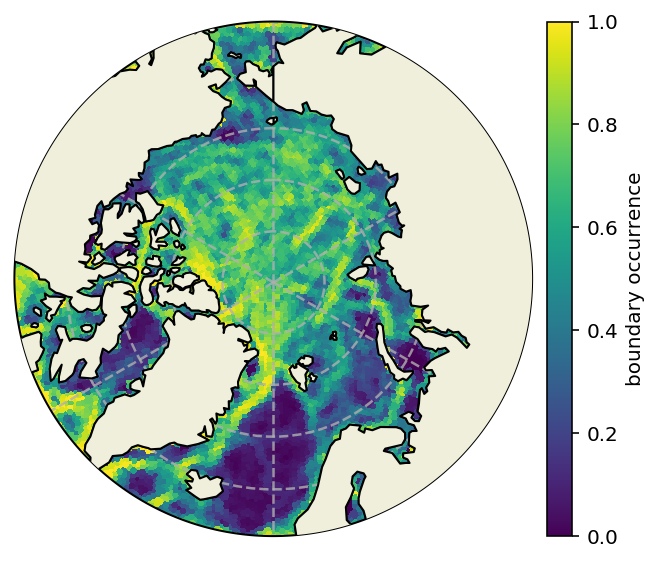

In [60]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"persistence_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             units = "boundary occurrence"
                                            )

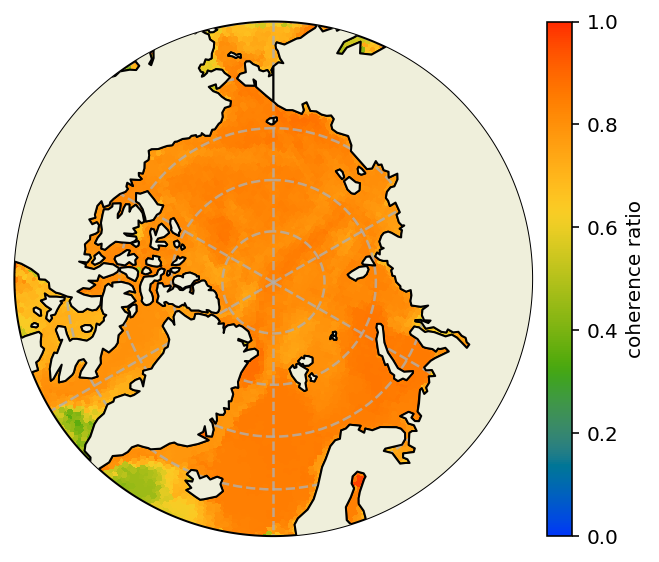

In [61]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio",
                                             export = "coherence_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

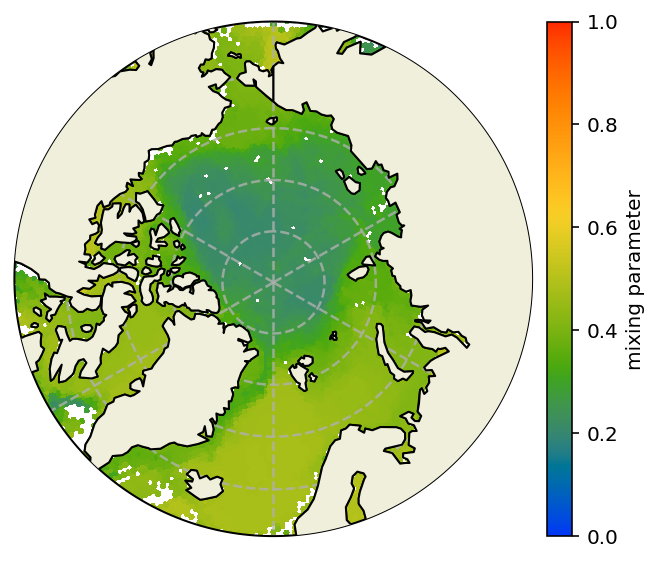

In [62]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter",
                                             export = "mixing_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2_ensemble.png"
                                            )

Plotting the difference between 1993-2002 and 2009-2018:

In [27]:
diff_mixing_september = avg_mixing_september_2009_2018 - avg_mixing_september_1993_2002
diff_coherence_september = avg_coherence_september_2009_2018 - avg_coherence_september_1993_2002
diff_boundary_september = avg_boundary_september_2009_2018 - avg_boundary_september_1993_2002

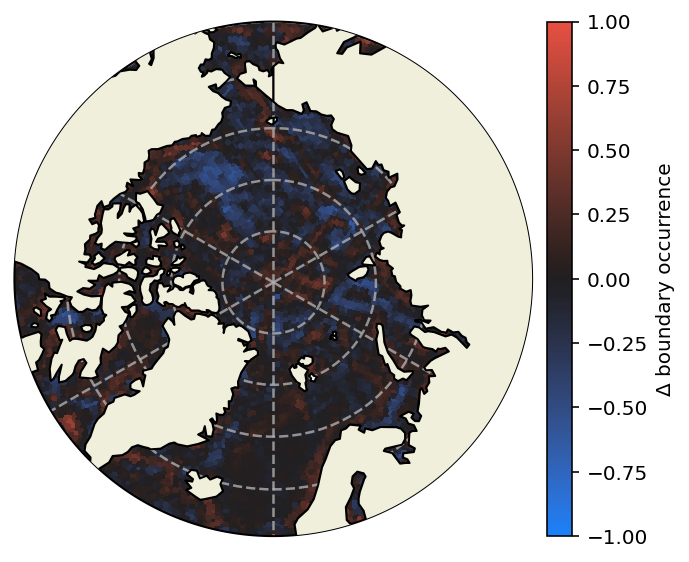

In [30]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             diff_boundary_september[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"diff_boundary_Rcmems_Pico11_S19932002-9-1_S20092018_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             colormap = cc.cm.bkr, 
                                             vmin = -1,
                                             vmax = 1,
                                             units = "Δ boundary occurrence"
                                            )

In [34]:
print(diff_mixing_september.min(), diff_mixing_september.max())

-0.15971700787654836 0.21400699804401202


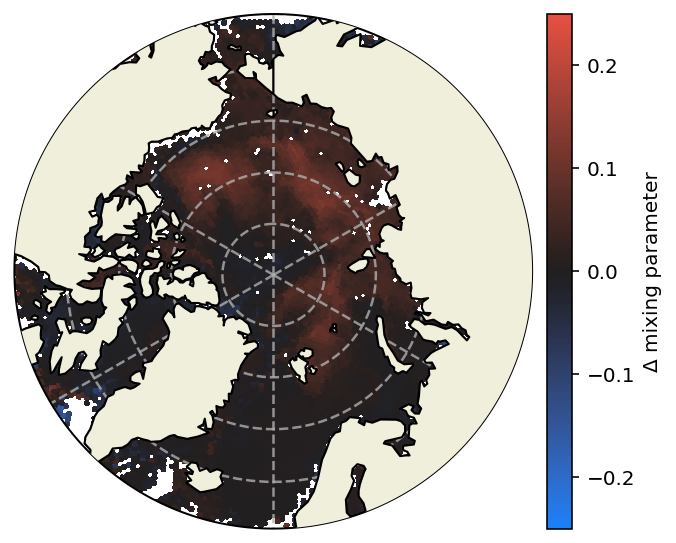

In [35]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             diff_mixing_september[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"diff_mixing_Rcmems_Pico11_S19932002-9-1_S20092018_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             colormap = cc.cm.bkr, 
                                             vmin = -0.25,
                                             vmax = 0.25,
                                             units = "Δ mixing parameter"
                                            )

In [36]:
print(diff_coherence_september.min(), diff_coherence_september.max())

-0.3264566428541338 0.3400472938201478


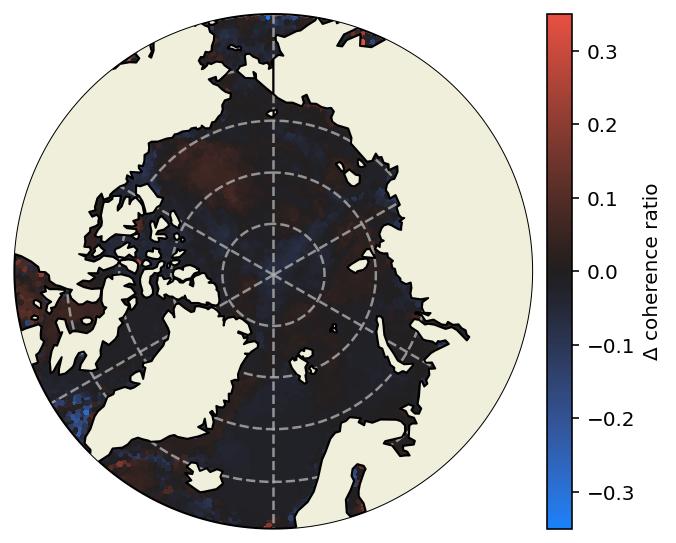

In [38]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             diff_coherence_september[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (5,5),
                                             export = f"diff_coherence_Rcmems_Pico11_S19932002-9-1_S20092018_D90_DT20_ODT24_Cico7_mt2_ensemble.png",
                                             cbar = True,
                                             polar = True,
                                             colormap = cc.cm.bkr, 
                                             vmin = -0.35,
                                             vmax = 0.35,
                                             units = "Δ coherence ratio"
                                            )